In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

plt.rcParams['figure.figsize'] = (30, 10)
plt.style.use('ggplot')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
np.set_printoptions(threshold=sys.maxsize)#np.set_printoptions(threshold=sys.maxsize)

import math
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
import re
import itertools

In [2]:
#df_vigil = pd.read_csv('../Cleaner/el vigil 170902018.txt_data_cleaned.csv', index_col=0)
df_vaquerias = pd.read_csv('../Cleaner/000960_Vaquerias,_Jalisco_meas_2017.09.04-2017.10.03.txt_data_cleaned.csv', index_col=0)
df = pd.read_csv('../Cleaner/001082__meas_2017.10.03-2018.01.23.txt_data_cleaned.csv', index_col=0) #igual a df_vaquerias
df_ech1 = pd.read_csv('../Cleaner/ech1 18092018.txt_data_cleaned.csv', index_col=0)

#df_vigil = df_vigil.rename(columns={'Date & Time Stamp': 'timestamp'})
df_vaquerias = df_vaquerias.rename(columns={'Date & Time Stamp': 'timestamp'})
df = df.rename(columns={'Date & Time Stamp': 'timestamp'})
df_ech1 = df_ech1.rename(columns={'Date & Time Stamp': 'timestamp'})


dfs = [df_vaquerias, df, df_ech1]

In [3]:
def construct_stats(df, sensor='anem', func=['correlation'], func_column='Avg', window = 10):
    """ Función construir estadísticas de los datos
    
        df: dataframe
        sensor: 'anem' anemometer, 'vane' windvane
        func: 'correlation', 'ratio', 'diff', 'all'
        func_column: 'Avg', 'SD', 'Min', 'Max'. Columna del dataframe a la cual queremos aplicar la función para obtener las estadisticas.
        windows: default=10. Ventana de correlación
        
        return: Dataframe con las stats nuevas
    """
    
    str_sensor = ['timestamp']
    str_sensor.append(sensor)
    str_default_channels = ['CH1', 'CH2', 'CH3', 'CH13', 'CH14'] if sensor == 'anem' else ['CH7', 'CH8']
    
    try:    
        ch_sensors = [x for x in df.columns if any(i.lower() in x.lower() for i in str_sensor)]
        ch_sensors = [x for x in ch_sensors if func_column in x]
        if len(ch_sensors) < 2:
            raise ValueError
            
    except ValueError:
        print(f'Las columnas del set de datos no especifican si el sensor es un {sensor}, se toma por default {str_default_channels} como {sensor}')
        ch_sensors = ['timestamp']
        for c in str_default_channels:
            ch_sensors.append(c + 'Avg')
            #ch_sensors.append(c + 'SD')
            #ch_sensors.append(c + 'Max')
            #ch_sensors.append(c + 'Min')
            
            
    df_sensors = df.loc[:, ch_sensors]

    
    if sensor == 'vane':
        func_column = '_deg_cos'
        df_sensors = df_sensors.iloc[:, df_sensors.columns.str.contains('Avg')]
        for col in df_sensors.columns:
            df_sensors[str(col) + '_cos'] = np.sin(np.deg2rad(df_sensors[col])) 
    
    
    for x in itertools.combinations(df_sensors.columns[~df_sensors.columns.str.contains('timestamp')], 2):
        if (str(func_column) in x[0] and str(func_column) in x[1]):

            # Fractions
            if ('ratio' in func) or ('all' in func):
                df_sensors[str(x[0] + 'VS' + x[1] + '_ratio')] = df_sensors[x[0]] / df_sensors[x[1]]

            # Rolling correlations           
            if ('correlation' in func) or ('all' in func):
                rolling_correlation = df_sensors[x[0]].rolling(window).corr(df_sensors[x[1]])
                df_sensors[str(x[0] + 'VS' + x[1] + '_correlation')] = rolling_correlation.values
                
            # Difference
            if ('diff' in func) or ('all' in func):
                if '_cos' in x[0] and '_cos' in x[1]:
                    df_sensors[str(x[0] + 'VS' + x[1] + '_diff')] = df_sensors[x[0]] - df_sensors[x[1]]

    return df_sensors

In [4]:
def sensor_anomalies(df, func='correlation', limit=10):
    """ Función para detectar anomalías entre sensores
    
        df: Dataframe con stadisticas construidas
        func: 'correlation', 'ratio', 'diff'. Función que se calculo en la construcción de las estadisticas
        limit: default=10. Límite en el cual se considera una anomalía.
        
        return: Dict con los indíces del dataframe donde se detectaron las anomalías.
    """

    
    
    dict_bad_anemometer = {}
    columns = []
    
    if (func == 'correlation') or (func == 'all'):
        columns.extend(df.columns[df.columns.str.contains('_correlation')])
        
    if (func == 'ratio') or (func == 'all'):
        columns.extend(df.columns[df.columns.str.contains('_ratio')])
        
    if (func == 'diff') or (func == 'all'):
        columns.extend(df.columns[df.columns.str.contains('_diff')])
        
    for col in columns:
        if (len(df[df[col] > limit].index.values) > 0) | (len(df[df[col] < limit].index.values) > 0):
            dict_bad_anemometer[col] = df[(df[col] > limit) | (df[col] < (-limit))].index.values
            dict_bad_anemometer[col] = np.append(dict_bad_anemometer[col], df[(df[col].isna())][col].index.values)
            dict_bad_anemometer[col] = np.append(dict_bad_anemometer[col], df[np.isinf(df[col])][col].index.values)
            dict_bad_anemometer[col] = np.sort(dict_bad_anemometer[col])
        
    return dict_bad_anemometer

In [6]:
stats_vane_dict = {}

for idx, df in enumerate(dfs):
    stats_vane_dict[idx] = construct_stats(df, sensor='vane', func='diff')

Las columnas del set de datos no especifican si el sensor es un vane, se toma por default ['CH7', 'CH8'] como vane


In [28]:
anomalies_vane_dict = {}

for idx, df in enumerate(stats_vane_dict):
    anomalies_vane_dict[idx] = sensor_anomalies(stats_vane_dict[idx], 'diff', limit=.5)

In [29]:
anomalies_vane_dict[0]

{'Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff': array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13,    14,    15,    16,    17,
           18,    19,    20,    21,    22,    23,    24,    25,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,
           36,    37,    38,    39,    40,    41,    42,    43,    44,
           45,    46,    47,    48,    49,    50,    51,    52,    53,
           54,    55,    56,    57,    58,    59,    60,    61,    62,
           63,    64,    65,    66,    67,    68,    69,    70,    71,
           72,    73,    74,    75,    76,    77,    78,    79,   142,
          279,   280,   281,   282,   283,   284,   285,   286,   287,
          288,   289,   290,   291,   292,   293,   294,   295,   296,
          297,   298,   299,   300,   301,   302,   303,   304,   305,
          306,   307,   308,   309,   310,   311,   312,   313,   314,
  

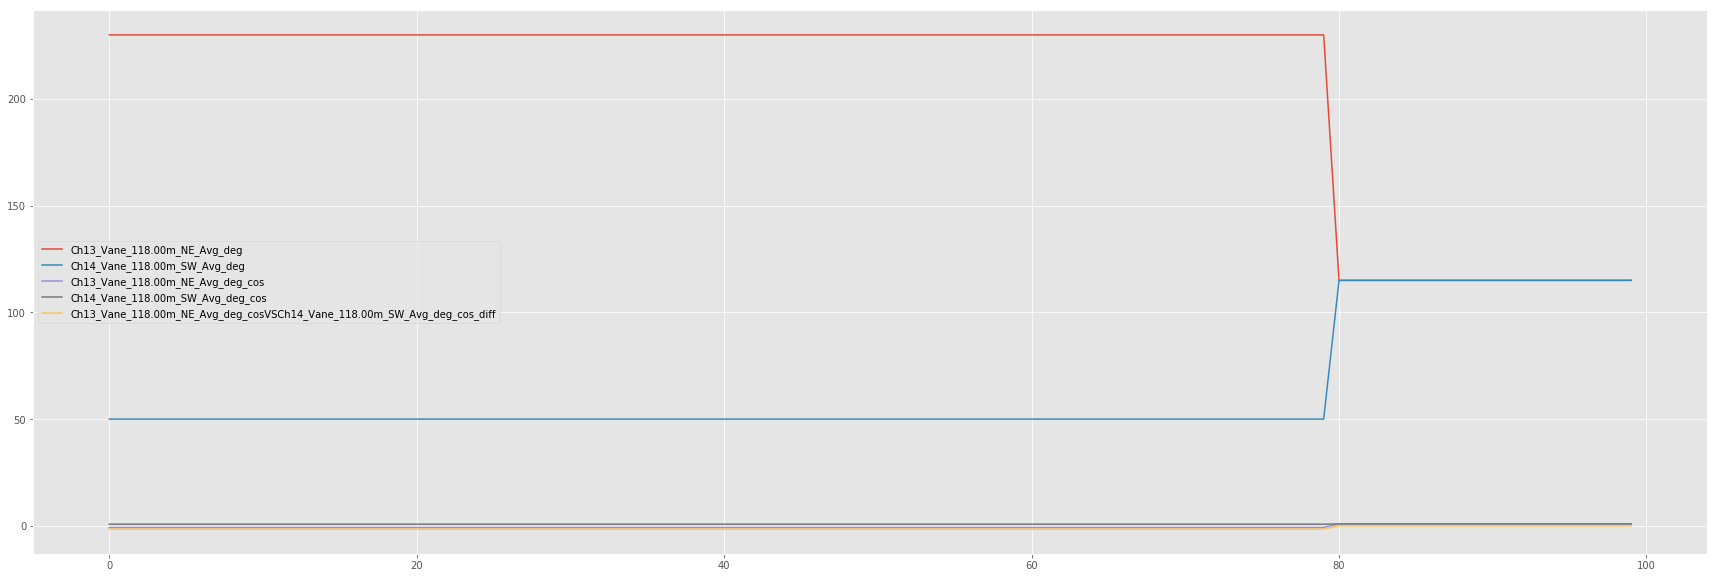

In [30]:
stats_vane_dict[0][0:100].plot()

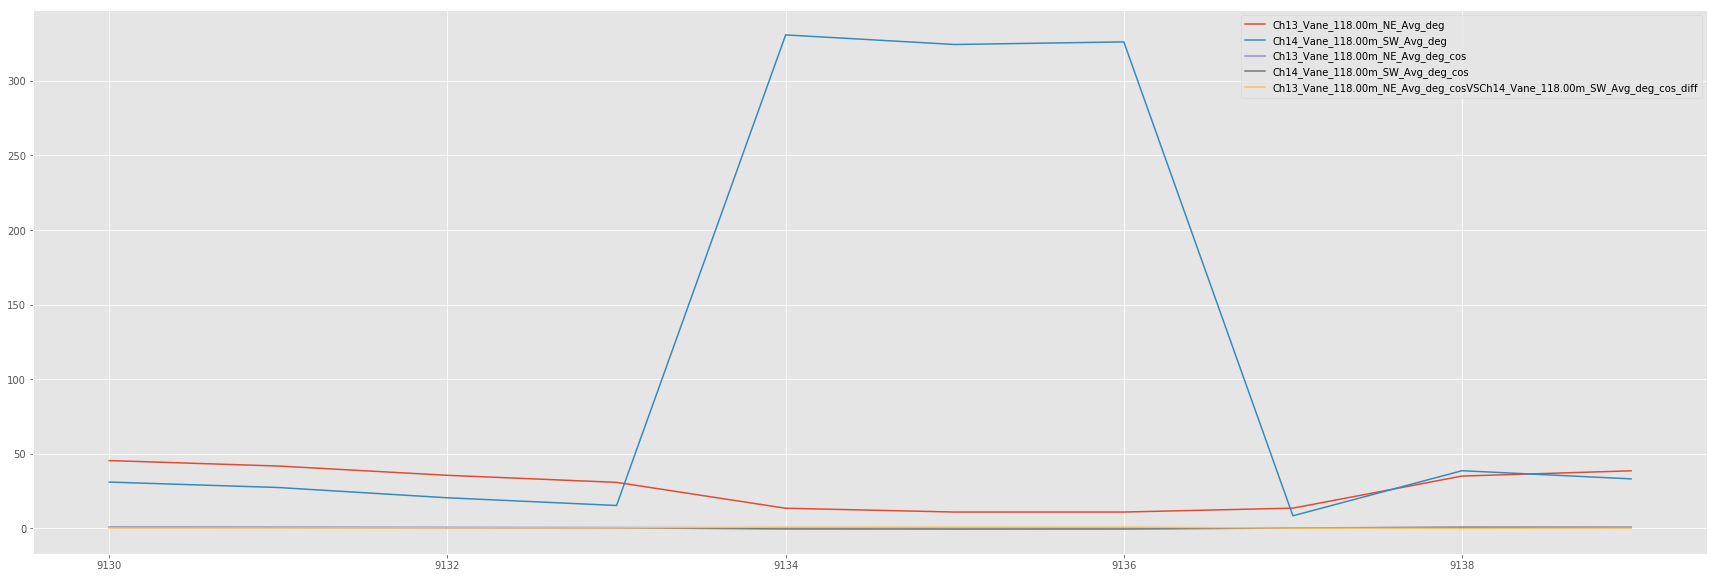

In [31]:
stats_vane_dict[0][9130:9140].plot()

In [32]:
anomalies_vane_dict[1]

{'Ch13_Vane_92.00m_WNW_Avg_deg_cosVSCh14_Vane_72.00m_WNW_Avg_deg_cos_diff': array([ 2390,  4280,  4281,  4305,  5318,  7116,  7323,  7993,  7994,
         7995,  8817,  8818,  9031, 10169, 10170, 10552, 10883, 10936,
        11749, 11942, 12040, 12239, 13051, 13052, 13353, 13354, 13355,
        13356, 14615, 14640, 15075, 15076, 15077, 15361, 15362, 16027,
        16028, 16029, 16108], dtype=int64)}

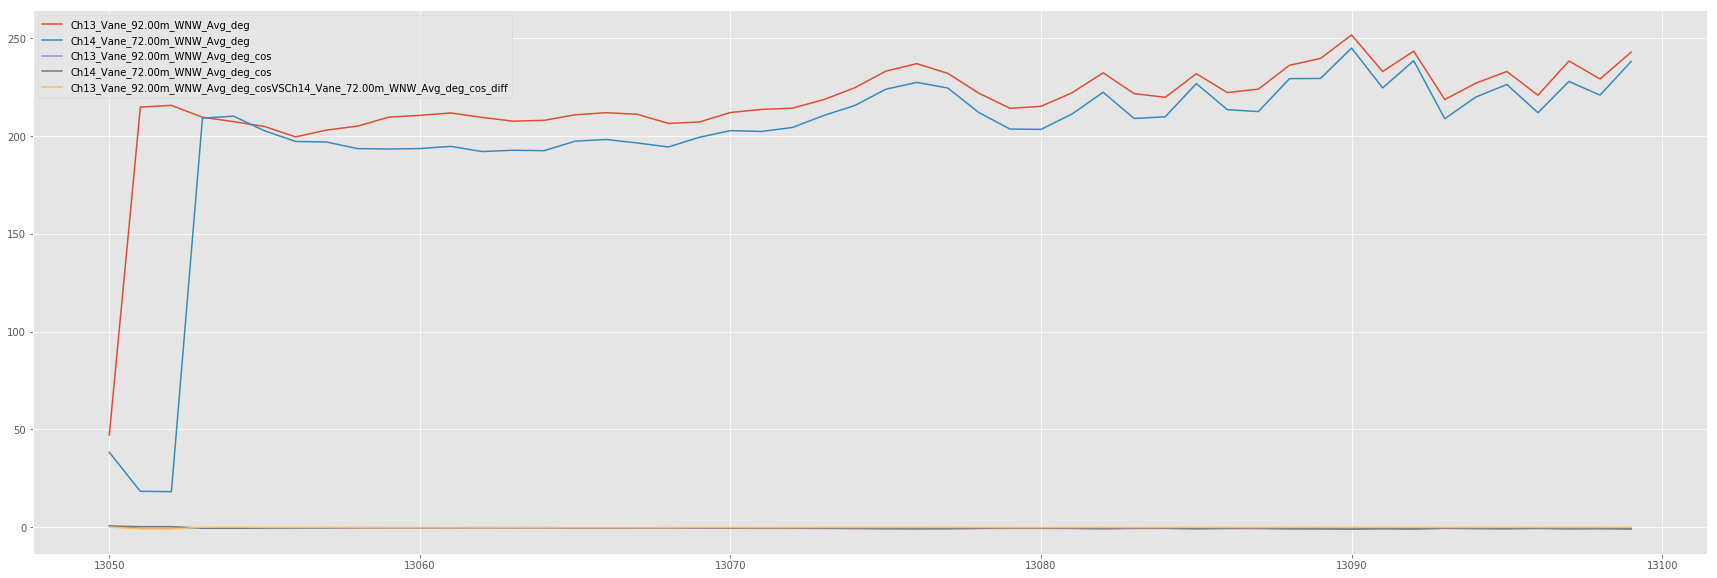

In [33]:
stats_vane_dict[1][13050:13100].plot()

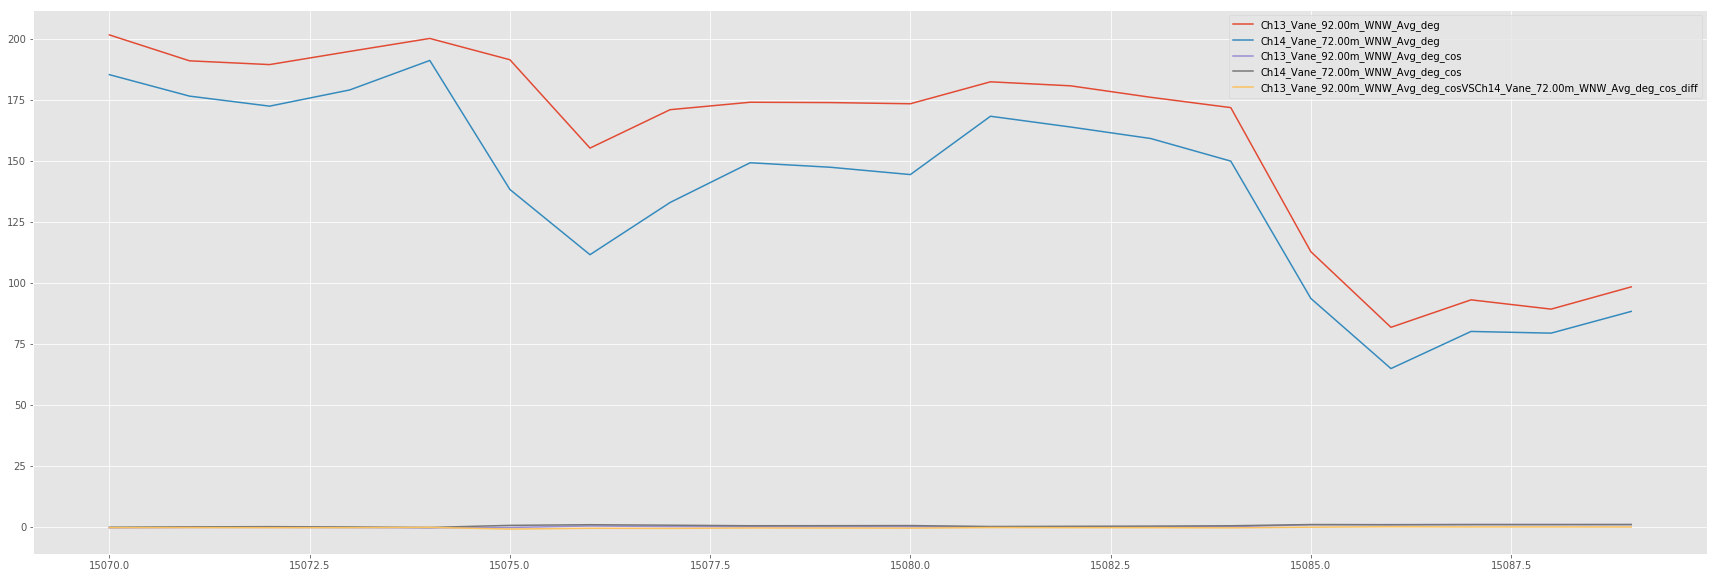

In [34]:
stats_vane_dict[1][15070:15090].plot()

In [35]:
anomalies_vane_dict[2]

{'CH7Avg_cosVSCH8Avg_cos_diff': array([    2,     3,     4,     5,     6,     7,     8,     9,    10,
           11,    23,    24,    29,    30,    36,    37,    38,    39,
          193,   353,   487,   535,   551,   552,   553,   554,   555,
          564,   657,   799,   961,   962,  1247,  1269,  1270,  1271,
         1272,  1273,  1274,  1276,  1277,  1293,  1294,  1688,  1689,
         1821,  1945,  1950,  1957,  1984,  1986,  1987,  1988,  2208,
         2225,  2233,  2234,  2235,  2236,  2243,  2263,  2264,  2265,
         2266,  2277,  2278,  2279,  2280,  2281,  2282,  2283,  2284,
         2285,  2286,  2287,  2288,  2334,  2335,  3746,  3834,  3839,
         3840,  4087,  4158,  4161,  4834,  5408,  5541,  5542,  5668,
         5670,  5671,  5676,  5699,  5733,  5926,  5927,  6518,  6519,
         6520,  6521,  6522,  6530,  6531,  6532,  6533,  6534,  6536,
         6537,  6538,  6540,  6541,  6718,  6719,  6847,  7538,  7539,
         7540,  7541,  7547,  7548,  7555,  75

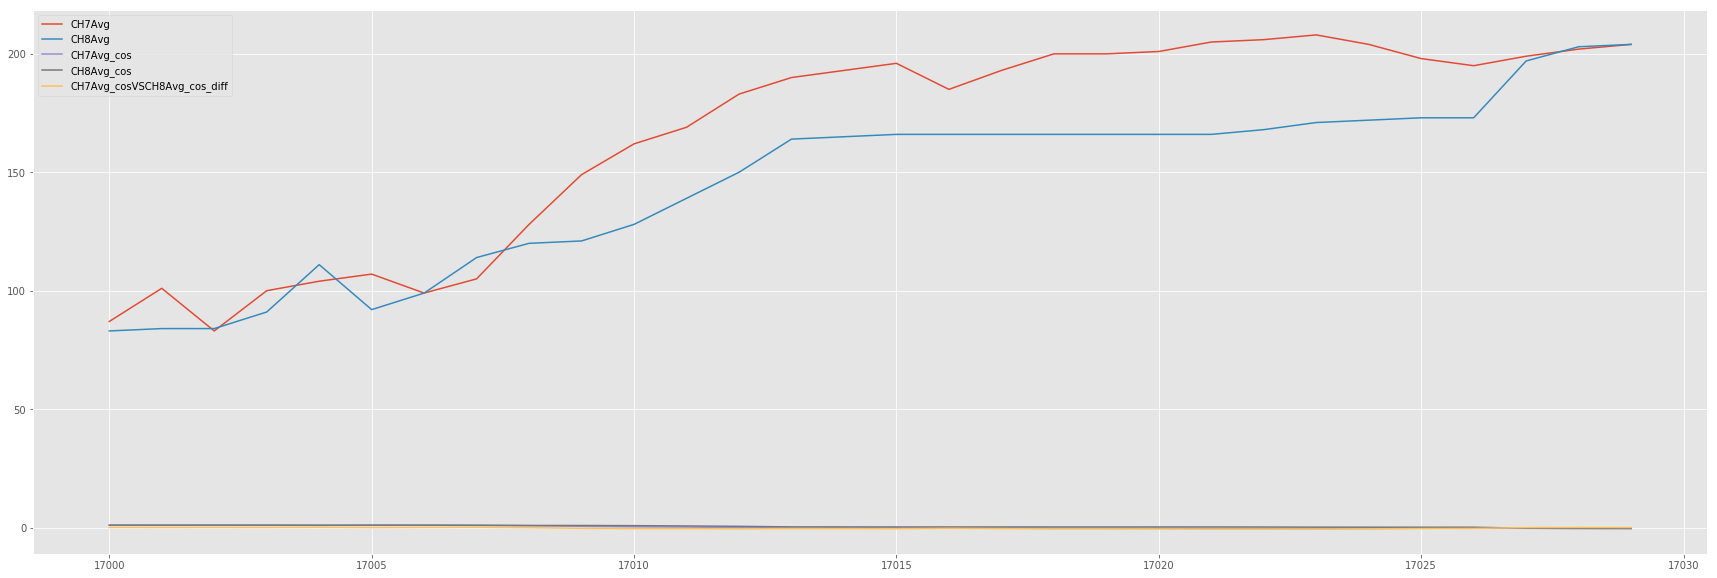

In [36]:
stats_vane_dict[2][17000:17030].plot()

In [37]:
stats_anem_dict = {}

for idx, df in enumerate(dfs):
    stats_anem_dict[idx] = construct_stats(df, sensor='anem', func='all', func_column='Avg')

Las columnas del set de datos no especifican si el sensor es un anem, se toma por default ['CH1', 'CH2', 'CH3', 'CH13', 'CH14'] como anem


In [38]:
anomalies_anem_dict = {}

for idx, df in enumerate(stats_anem_dict):
    anomalies_anem_dict[idx] = sensor_anomalies(stats_anem_dict[idx], 'ratio', limit=10)

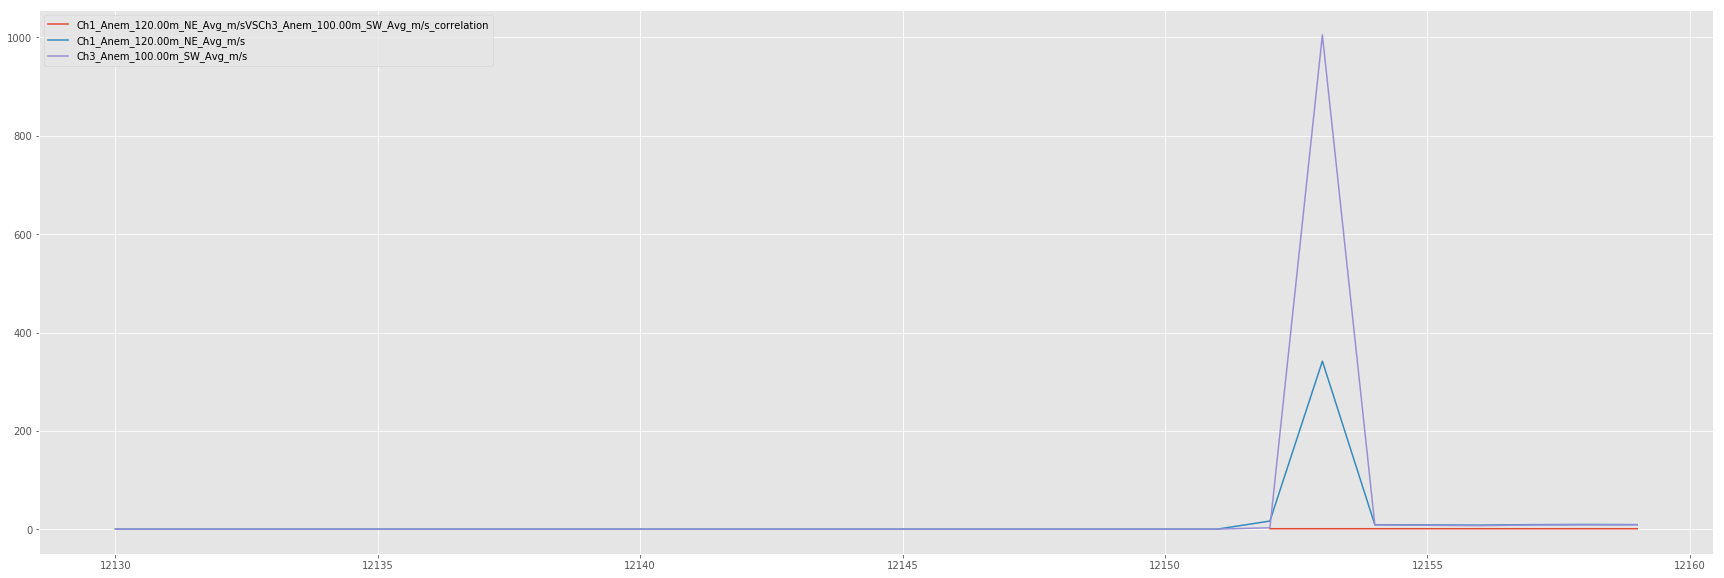

In [39]:
stats_anem_dict[0][['Ch1_Anem_120.00m_NE_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation', 'Ch1_Anem_120.00m_NE_Avg_m/s', 'Ch3_Anem_100.00m_SW_Avg_m/s']][12130:12160].plot()

In [40]:
stats_anem_dict[0][['Ch1_Anem_120.00m_NE_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation', 'Ch1_Anem_120.s00m_NE_Avg_m/s', 'Ch3_Anem_100.00m_SW_Avg_m/s']][50:120].plot()

KeyError: "['Ch1_Anem_120.s00m_NE_Avg_m/s'] not in index"

In [66]:
df_vaquerias.head()

,Timestamp,Ch1_Anem_120.00m_NE_Avg_m/s,Ch1_Anem_120.00m_NE_SD_m/s,Ch1_Anem_120.00m_NE_Min_m/s,Ch1_Anem_120.00m_NE_Max_m/s,Ch1_Anem_120.00m_NE_Gust_m/s,Ch2_Anem_120.00m_SW_Avg_m/s,Ch2_Anem_120.00m_SW_SD_m/s,Ch2_Anem_120.00m_SW_Min_m/s,Ch2_Anem_120.00m_SW_Max_m/s,Ch2_Anem_120.00m_SW_Gust_m/s,Ch3_Anem_100.00m_SW_Avg_m/s,Ch3_Anem_100.00m_SW_SD_m/s,Ch3_Anem_100.00m_SW_Min_m/s,Ch3_Anem_100.00m_SW_Max_m/s,Ch3_Anem_100.00m_SW_Gust_m/s,Ch4_Anem_80.00m_NE_Avg_m/s,Ch4_Anem_80.00m_NE_SD_m/s,Ch4_Anem_80.00m_NE_Min_m/s,Ch4_Anem_80.00m_NE_Max_m/s,Ch4_Anem_80.00m_NE_Gust_m/s,Ch5_Anem_80.00m_SW_Avg_m/s,Ch5_Anem_80.00m_SW_SD_m/s,Ch5_Anem_80.00m_SW_Min_m/s,Ch5_Anem_80.00m_SW_Max_m/s,Ch5_Anem_80.00m_SW_Gust_m/s,Ch6_Anem_60.00m_SW_Avg_m/s,Ch6_Anem_60.00m_SW_SD_m/s,Ch6_Anem_60.00m_SW_Min_m/s,Ch6_Anem_60.00m_SW_Max_m/s,Ch6_Anem_60.00m_SW_Gust_m/s,Ch13_Vane_118.00m_NE_Avg_deg,Ch13_Vane_118.00m_NE_SD_deg,Ch13_Vane_118.00m_NE_GustDir_deg,Ch14_Vane_118.00m_SW_Avg_deg,Ch14_Vane_118.00m_SW_SD_deg,Ch14_Vane_118.00m_SW_GustDir_deg,Ch16_Analog_116.00m_S_Avg_C,Ch16_Analog_116.00m_S_SD_C,Ch16_Analog_116.00m_S_Min_C,Ch16_Analog_116.00m_S_Max_C,Ch17_Analog_20.00m_S_Avg_C,Ch17_Analog_20.00m_S_SD_C,Ch17_Analog_20.00m_S_Min_C,Ch17_Analog_20.00m_S_Max_C
0,2017-09-04 10:28:44,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
1,2017-09-04 10:29:00,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
2,2017-09-04 10:30:00,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
3,2017-09-04 10:31:00,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
4,2017-09-04 10:31:21,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38


In [67]:
df_vaquerias_stats = construct_stats(df_vaquerias, sensor='Anem', func='correlation', func_column='Avg', window=10)

In [68]:
df_vaquerias_stats.head(50)
# 	Ch3_Anem_100.00m_SW_Avg_m/s 	
#   Ch1_Anem_120.00m_NE_Avg_m/s 	

,Ch1_Anem_120.00m_NE_Avg_m/s,Ch2_Anem_120.00m_SW_Avg_m/s,Ch3_Anem_100.00m_SW_Avg_m/s,Ch4_Anem_80.00m_NE_Avg_m/s,Ch5_Anem_80.00m_SW_Avg_m/s,Ch6_Anem_60.00m_SW_Avg_m/s,Ch1_Anem_120.00m_NE_Avg_m/sVSCh2_Anem_120.00m_SW_Avg_m/s_correlation,Ch1_Anem_120.00m_NE_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation,Ch1_Anem_120.00m_NE_Avg_m/sVSCh4_Anem_80.00m_NE_Avg_m/s_correlation,Ch1_Anem_120.00m_NE_Avg_m/sVSCh5_Anem_80.00m_SW_Avg_m/s_correlation,Ch1_Anem_120.00m_NE_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation,Ch2_Anem_120.00m_SW_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation,Ch2_Anem_120.00m_SW_Avg_m/sVSCh4_Anem_80.00m_NE_Avg_m/s_correlation,Ch2_Anem_120.00m_SW_Avg_m/sVSCh5_Anem_80.00m_SW_Avg_m/s_correlation,Ch2_Anem_120.00m_SW_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation,Ch3_Anem_100.00m_SW_Avg_m/sVSCh4_Anem_80.00m_NE_Avg_m/s_correlation,Ch3_Anem_100.00m_SW_Avg_m/sVSCh5_Anem_80.00m_SW_Avg_m/s_correlation,Ch3_Anem_100.00m_SW_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation,Ch4_Anem_80.00m_NE_Avg_m/sVSCh5_Anem_80.00m_SW_Avg_m/s_correlation,Ch4_Anem_80.00m_NE_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation,Ch5_Anem_80.00m_SW_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation
0,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.22192,0.2382,0.23845,0.23843,0.22588,0.2474,NaN,NaN,-inf,inf,NaN,NaN,-inf,NaN,-inf,-inf,NaN,NaN,-inf,-inf,inf


In [69]:
df_vaquerias_anomalies = sensor_anomalies(df_vaquerias_stats, func='correlation', limit = .7)

In [70]:
df_vaquerias_anomalies['Ch1_Anem_120.00m_NE_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation']


# 0 1439

# 10510 12200

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    83,    84,    84,    85,    85,    86,
          86,    87,    87,    88,    88,    89,    90,    91,    92,
          93,    94,    95,    96,    97,    98,    99,   100,   101,
         102,   103,   104,   105,   106,   107,   108,   109,   110,
         111,   112,   113,   114,   115,   116,   117,   118,   119,
         120,   121,

In [75]:
df_vaquerias_stats.columns

Index(['Ch1_Anem_120.00m_NE_Avg_m/s', 'Ch2_Anem_120.00m_SW_Avg_m/s',
       'Ch3_Anem_100.00m_SW_Avg_m/s', 'Ch4_Anem_80.00m_NE_Avg_m/s',
       'Ch5_Anem_80.00m_SW_Avg_m/s', 'Ch6_Anem_60.00m_SW_Avg_m/s',
       'Ch1_Anem_120.00m_NE_Avg_m/sVSCh2_Anem_120.00m_SW_Avg_m/s_correlation',
       'Ch1_Anem_120.00m_NE_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation',
       'Ch1_Anem_120.00m_NE_Avg_m/sVSCh4_Anem_80.00m_NE_Avg_m/s_correlation',
       'Ch1_Anem_120.00m_NE_Avg_m/sVSCh5_Anem_80.00m_SW_Avg_m/s_correlation',
       'Ch1_Anem_120.00m_NE_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation',
       'Ch2_Anem_120.00m_SW_Avg_m/sVSCh3_Anem_100.00m_SW_Avg_m/s_correlation',
       'Ch2_Anem_120.00m_SW_Avg_m/sVSCh4_Anem_80.00m_NE_Avg_m/s_correlation',
       'Ch2_Anem_120.00m_SW_Avg_m/sVSCh5_Anem_80.00m_SW_Avg_m/s_correlation',
       'Ch2_Anem_120.00m_SW_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation',
       'Ch3_Anem_100.00m_SW_Avg_m/sVSCh4_Anem_80.00m_NE_Avg_m/s_correlation',
       'Ch3_A

In [157]:
df_vaquerias_stats[['Ch3_Anem_100.00m_SW_Avg_m/s', 'Ch6_Anem_60.00m_SW_Avg_m/s', 'Ch3_Anem_100.00m_SW_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation']][0:1500]

,Ch3_Anem_100.00m_SW_Avg_m/s,Ch6_Anem_60.00m_SW_Avg_m/s,Ch3_Anem_100.00m_SW_Avg_m/sVSCh6_Anem_60.00m_SW_Avg_m/s_correlation
10671,0.268490,0.360000,inf
10672,0.268490,0.360000,inf
10673,0.268490,0.360000,inf
10674,0.268490,0.360000,inf
10675,0.268490,0.360000,inf
10676,0.268490,0.360000,inf
10677,0.268490,0.360000,inf
10678,0.268490,0.360000,inf
10679,0.268490,0.360000,inf
10680,0.268490,0.360000,inf


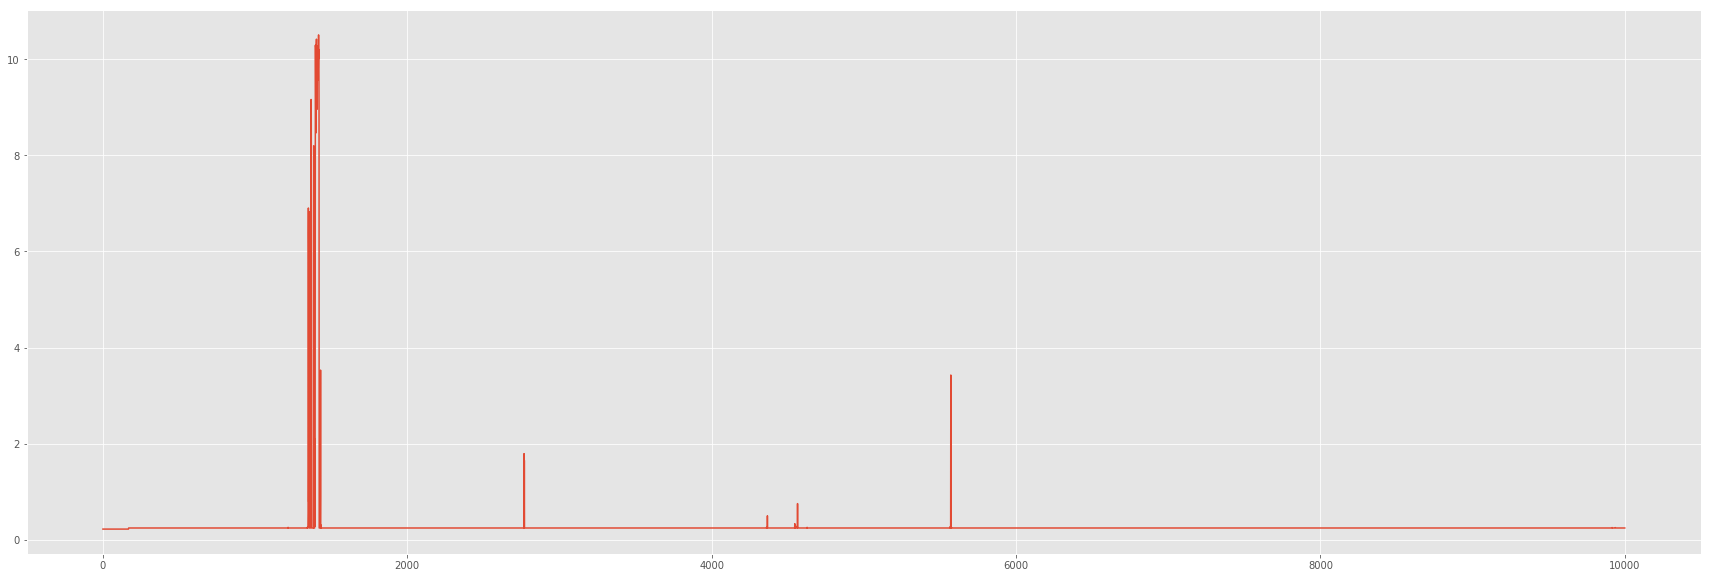

In [84]:
#df_vaquerias_stats[['Ch1_Anem_120.00m_NE_Avg_m/s', 'Ch3_Anem_100.00m_SW_Avg_m/s']][10510:12210].plot()
df_vaquerias_stats['Ch1_Anem_120.00m_NE_Avg_m/s'][0:10000].plot()

<h3>Wind Vanes</h3>

In [5]:
df_vaquerias.head(5)

,Timestamp,Ch1_Anem_120.00m_NE_Avg_m/s,Ch1_Anem_120.00m_NE_SD_m/s,Ch1_Anem_120.00m_NE_Min_m/s,Ch1_Anem_120.00m_NE_Max_m/s,Ch1_Anem_120.00m_NE_Gust_m/s,Ch2_Anem_120.00m_SW_Avg_m/s,Ch2_Anem_120.00m_SW_SD_m/s,Ch2_Anem_120.00m_SW_Min_m/s,Ch2_Anem_120.00m_SW_Max_m/s,Ch2_Anem_120.00m_SW_Gust_m/s,Ch3_Anem_100.00m_SW_Avg_m/s,Ch3_Anem_100.00m_SW_SD_m/s,Ch3_Anem_100.00m_SW_Min_m/s,Ch3_Anem_100.00m_SW_Max_m/s,Ch3_Anem_100.00m_SW_Gust_m/s,Ch4_Anem_80.00m_NE_Avg_m/s,Ch4_Anem_80.00m_NE_SD_m/s,Ch4_Anem_80.00m_NE_Min_m/s,Ch4_Anem_80.00m_NE_Max_m/s,Ch4_Anem_80.00m_NE_Gust_m/s,Ch5_Anem_80.00m_SW_Avg_m/s,Ch5_Anem_80.00m_SW_SD_m/s,Ch5_Anem_80.00m_SW_Min_m/s,Ch5_Anem_80.00m_SW_Max_m/s,Ch5_Anem_80.00m_SW_Gust_m/s,Ch6_Anem_60.00m_SW_Avg_m/s,Ch6_Anem_60.00m_SW_SD_m/s,Ch6_Anem_60.00m_SW_Min_m/s,Ch6_Anem_60.00m_SW_Max_m/s,Ch6_Anem_60.00m_SW_Gust_m/s,Ch13_Vane_118.00m_NE_Avg_deg,Ch13_Vane_118.00m_NE_SD_deg,Ch13_Vane_118.00m_NE_GustDir_deg,Ch14_Vane_118.00m_SW_Avg_deg,Ch14_Vane_118.00m_SW_SD_deg,Ch14_Vane_118.00m_SW_GustDir_deg,Ch16_Analog_116.00m_S_Avg_C,Ch16_Analog_116.00m_S_SD_C,Ch16_Analog_116.00m_S_Min_C,Ch16_Analog_116.00m_S_Max_C,Ch17_Analog_20.00m_S_Avg_C,Ch17_Analog_20.00m_S_SD_C,Ch17_Analog_20.00m_S_Min_C,Ch17_Analog_20.00m_S_Max_C
0,2017-09-04 10:28:44,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
1,2017-09-04 10:29:00,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
2,2017-09-04 10:30:00,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
3,2017-09-04 10:31:00,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38
4,2017-09-04 10:31:21,0.22192,0.0,0.22192,0.22192,0.22192,0.2382,0.0,0.2382,0.2382,0.2382,0.23845,0.0,0.23845,0.23845,0.23845,0.23843,0.0,0.23843,0.23843,0.23843,0.22588,0.0,0.22588,0.22588,0.22588,0.2474,0.0,0.2474,0.2474,0.2474,230.0,0.0,230.0,50.0,0.0,50.0,-86.38,0.0,-86.38,-86.38,-86.38,0.0,-86.38,-86.38


In [6]:
df_vaquerias_stats = construct_stats(df_vaquerias, sensor='vane', func='diff', func_column='Avg')

In [7]:
df_vaquerias_stats.head()

,Ch13_Vane_118.00m_NE_Avg_deg,Ch14_Vane_118.00m_SW_Avg_deg,Ch13_Vane_118.00m_NE_Avg_deg_cos,Ch14_Vane_118.00m_SW_Avg_deg_cos,Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff
0,230.0,50.0,-0.766044,0.766044,-1.532089
1,230.0,50.0,-0.766044,0.766044,-1.532089
2,230.0,50.0,-0.766044,0.766044,-1.532089
3,230.0,50.0,-0.766044,0.766044,-1.532089
4,230.0,50.0,-0.766044,0.766044,-1.532089


In [33]:
df_vaquerias_anomalies = sensor_anomalies(df_vaquerias_stats, func='diff', limit = 0.2)

In [34]:
df_vaquerias_anomalies

{'Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff': array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
            9,    10,    11,    12,    13,    14,    15,    16,    17,
           18,    19,    20,    21,    22,    23,    24,    25,    26,
           27,    28,    29,    30,    31,    32,    33,    34,    35,
           36,    37,    38,    39,    40,    41,    42,    43,    44,
           45,    46,    47,    48,    49,    50,    51,    52,    53,
           54,    55,    56,    57,    58,    59,    60,    61,    62,
           63,    64,    65,    66,    67,    68,    69,    70,    71,
           72,    73,    74,    75,    76,    77,    78,    79,   142,
          269,   270,   271,   272,   273,   274,   275,   276,   277,
          278,   279,   280,   281,   282,   283,   284,   285,   286,
          287,   288,   289,   290,   291,   292,   293,   294,   295,
          296,   297,   298,   299,   300,   301,   302,   303,   304,
  

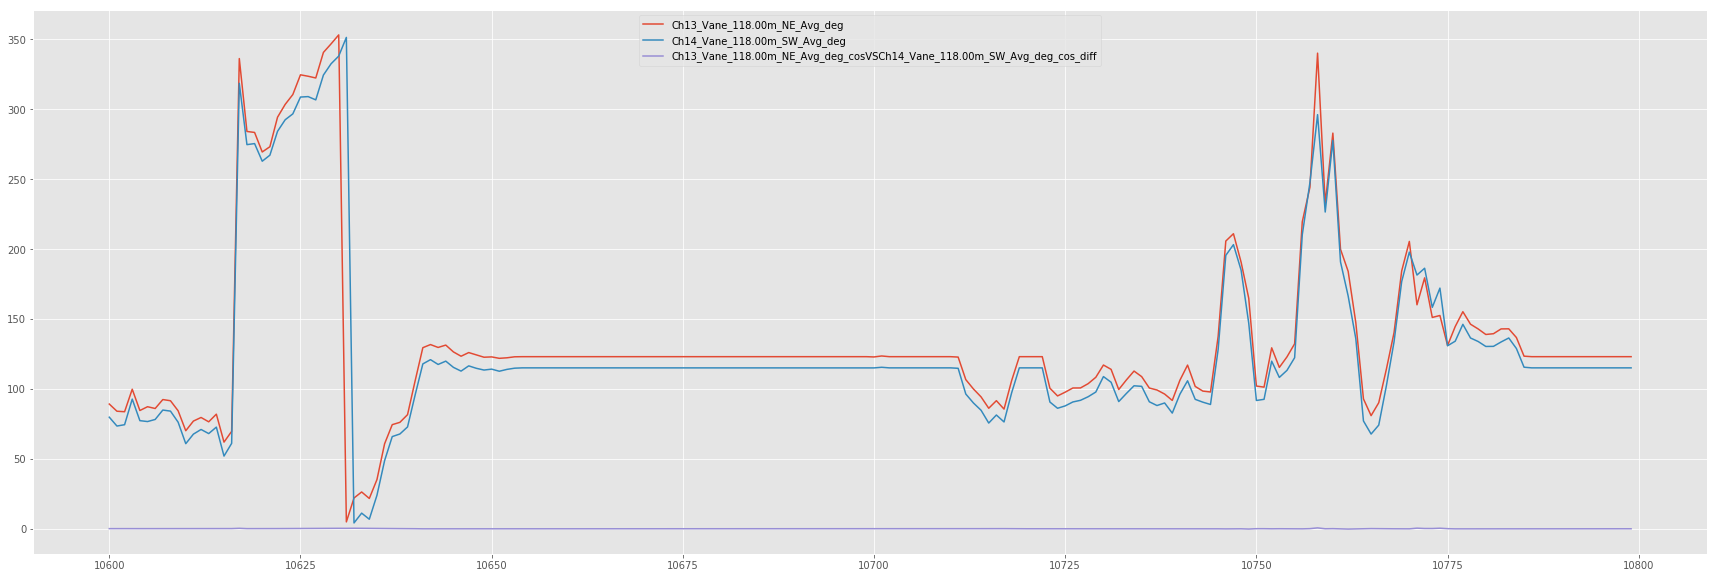

In [57]:
df_vaquerias_stats[['Ch13_Vane_118.00m_NE_Avg_deg', 'Ch14_Vane_118.00m_SW_Avg_deg', 'Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff']][10600:10800].plot()

In [65]:
df_vaquerias[['Timestamp','Ch13_Vane_118.00m_NE_Avg_deg', 'Ch14_Vane_118.00m_SW_Avg_deg']][4400:5000]

,Timestamp,Ch13_Vane_118.00m_NE_Avg_deg,Ch14_Vane_118.00m_SW_Avg_deg
4400,2017-09-08 13:24:00,52.02,50.25
4401,2017-09-08 13:25:00,55.28,53.26
4402,2017-09-08 13:26:00,57.17,52.38
4403,2017-09-08 13:27:00,60.26,58.31
4404,2017-09-08 13:28:00,67.52,68.08
4405,2017-09-08 13:29:00,69.70,72.02
4406,2017-09-08 13:30:00,58.55,59.06
4407,2017-09-08 13:30:35,59.91,61.30
4408,2017-09-08 13:31:00,62.64,63.50
4409,2017-09-08 13:32:00,63.43,61.69


In [53]:
df_vaquerias.loc[1300:1400, 'Timestamp']

1300    2017-09-06 09:50:00
1301    2017-09-06 09:51:00
1302    2017-09-06 09:52:00
1303    2017-09-06 09:53:00
1304    2017-09-06 09:54:00
1305    2017-09-06 09:55:00
1306    2017-09-06 09:56:00
1307    2017-09-06 09:57:00
1308    2017-09-06 09:58:00
1309    2017-09-06 09:59:00
1310    2017-09-06 10:00:00
1311    2017-09-06 10:01:00
1312    2017-09-06 10:02:00
1313    2017-09-06 10:03:00
1314    2017-09-06 10:04:00
1315    2017-09-06 10:05:00
1316    2017-09-06 10:06:00
1317    2017-09-06 10:07:00
1318    2017-09-06 10:08:00
1319    2017-09-06 10:09:00
1320    2017-09-06 10:10:00
1321    2017-09-06 10:11:00
1322    2017-09-06 10:12:00
1323    2017-09-06 10:13:00
1324    2017-09-06 10:14:00
1325    2017-09-06 10:15:00
1326    2017-09-06 10:16:00
1327    2017-09-06 10:17:00
1328    2017-09-06 10:18:00
1329    2017-09-06 10:19:00
1330    2017-09-06 10:20:00
1331    2017-09-06 10:21:00
1332    2017-09-06 10:22:00
1333    2017-09-06 10:23:00
1334    2017-09-06 10:24:00
1335    2017-09-06 1

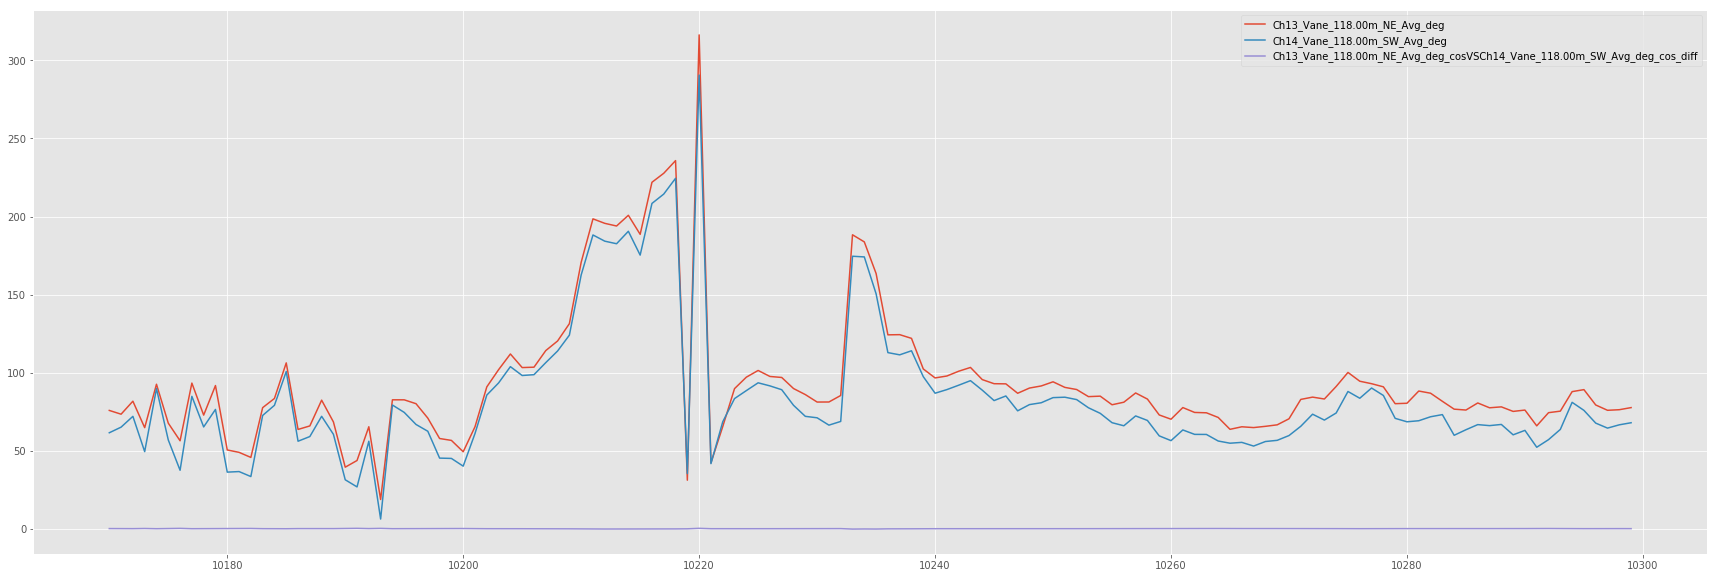

In [40]:
df_vaquerias_stats[['Ch13_Vane_118.00m_NE_Avg_deg', 'Ch14_Vane_118.00m_SW_Avg_deg', 'Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff']][10170:10300].plot()

In [47]:
df_vaquerias.loc[10170:10300, 'Timestamp']

10170    2017-09-19 12:20:00
10171    2017-09-19 12:30:00
10172    2017-09-19 12:40:00
10173    2017-09-19 12:50:00
10174    2017-09-19 13:00:00
10175    2017-09-19 13:10:00
10176    2017-09-19 13:20:00
10177    2017-09-19 13:30:00
10178    2017-09-19 13:40:00
10179    2017-09-19 13:50:00
10180    2017-09-19 14:00:00
10181    2017-09-19 14:10:00
10182    2017-09-19 14:20:00
10183    2017-09-19 14:30:00
10184    2017-09-19 14:40:00
10185    2017-09-19 14:50:00
10186    2017-09-19 15:00:00
10187    2017-09-19 15:10:00
10188    2017-09-19 15:20:00
10189    2017-09-19 15:30:00
10190    2017-09-19 15:40:00
10191    2017-09-19 15:50:00
10192    2017-09-19 16:00:00
10193    2017-09-19 16:10:00
10194    2017-09-19 16:20:00
10195    2017-09-19 16:30:00
10196    2017-09-19 16:40:00
10197    2017-09-19 16:50:00
10198    2017-09-19 17:00:00
10199    2017-09-19 17:10:00
10200    2017-09-19 17:20:00
10201    2017-09-19 17:30:00
10202    2017-09-19 17:40:00
10203    2017-09-19 17:50:00
10204    2017-

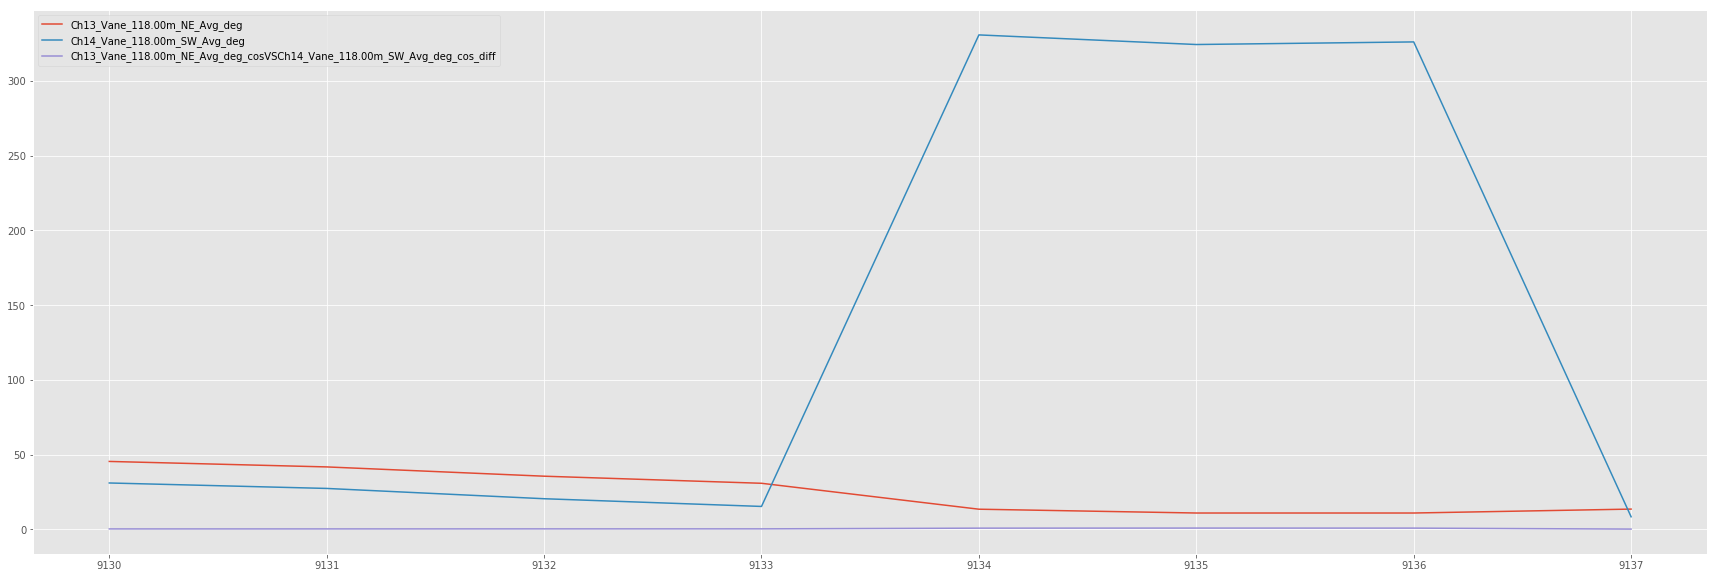

In [13]:
df_vaquerias_stats[['Ch13_Vane_118.00m_NE_Avg_deg', 'Ch14_Vane_118.00m_SW_Avg_deg', 'Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff']][9130:9138].plot()

In [14]:
df_vaquerias_stats[['Ch13_Vane_118.00m_NE_Avg_deg', 'Ch14_Vane_118.00m_SW_Avg_deg', 'Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff']][9130:9138]

,Ch13_Vane_118.00m_NE_Avg_deg,Ch14_Vane_118.00m_SW_Avg_deg,Ch13_Vane_118.00m_NE_Avg_deg_cosVSCh14_Vane_118.00m_SW_Avg_deg_cos_diff
9130,45.37,30.95,0.197368
9131,41.70,27.30,0.206581
9132,35.49,20.41,0.231825
9133,30.75,15.25,0.248262
9134,13.40,330.84,0.718998
9135,10.85,324.41,0.770219
9136,10.85,326.15,0.745259
9137,13.47,8.33,0.088062


In [15]:
diff_ch13_ch14 = df_vaquerias_stats['Ch13_Vane_118.00m_NE_Avg_deg'][9130:9138] - df_vaquerias_stats['Ch14_Vane_118.00m_SW_Avg_deg'][9130:9138]

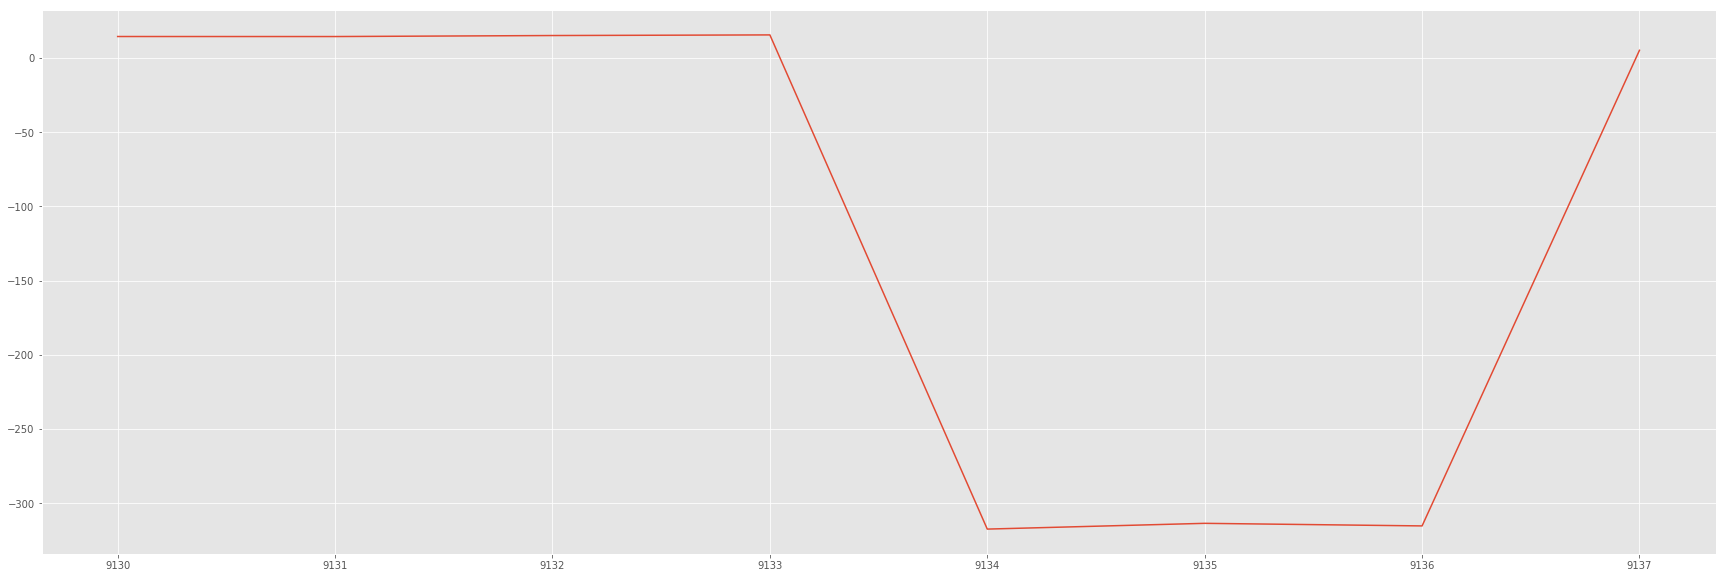

In [16]:
diff_ch13_ch14.plot()